In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # для удаления стоп-слов
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')    # для приведения слов в нормальную форму (Лемматизация)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Домашнее задание к лекции "Статистика. Практика"

In [ ]:
# !pip install --upgrade scipy

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv')
df.head(3)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E


# **Задание 1**
Ответьте на следующие вопросы:

1) Как критики относятся к спортивным играм?

2) Критикам нравятся больше игры на PC или на PS4?

3) Критикам больше нравятся стрелялки или стратегии?

In [ ]:
list_col = ['Critic_Score', 'Genre', 'Platform'] # столбцы данных для всех 3 подзадач
df = df[list_col]
df.head(3)

,Critic_Score,Genre,Platform
0,76.0,Sports,Wii
1,NaN,Platform,NES
2,82.0,Racing,Wii


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Critic_Score  8137 non-null   float64
 1   Genre         16717 non-null  object 
 2   Platform      16719 non-null  object 
dtypes: float64(1), object(2)
memory usage: 392.0+ KB


In [ ]:
df_nonan = df.loc[df.Critic_Score.isna() == False] # исключаем np.nan для расчета выбросов в "Critic_Score"
df_nonan.Critic_Score.isna().sum()

0

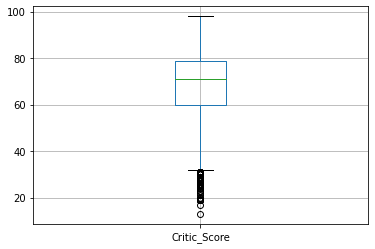

In [ ]:
df_nonan.boxplot() # в "Critic_Score" есть выбросы, надо их исключить

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  


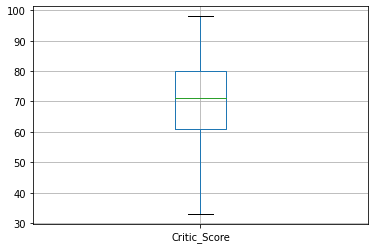

In [ ]:
q1     = df_nonan.Critic_Score.quantile(0.25)
q3     = df_nonan.Critic_Score.quantile(0.75)
iqr    = q3 - q1                 # межквартильный размах
lower_bound  = q1 - (1.45 * iqr) # нижняя граница диапазона
higher_bound = q3 + (1.45 * iqr) # верхняя граница диапазона

# данные без выбросов:
df_without = df_nonan.loc[df_nonan.Critic_Score.between(lower_bound, higher_bound, inclusive = True)]
df_without.boxplot()

In [ ]:
# посмотрим, например, на различие средних ДО и ПОСЛЕ удаления выбросов:
print(round(df.Critic_Score.mean(), 1))
print(round(df_without.Critic_Score.mean(), 1))

69.0
69.5


**1) Как критики относятся к спортивным играм?**



In [ ]:
sport = df_without.loc[df_without.Genre == 'Sports']
sport.Genre.unique()

array(['Sports'], dtype=object)

In [ ]:
# H0: среднее отношение критиков к спортивным играм "Sports" <= 70 баллов
# H1: среднее отношение критиков к спортивным играм "Sports" более 70 баллов
#     пороговый уровень статистической значимости: 0.05

In [ ]:
res = st.ttest_1samp(sport.Critic_Score, popmean = 70, alternative = 'greater')
print(f'pvalue: {res.pvalue:.2e}')
print(f'Средняя оценка критиков: {round(sport.Critic_Score.mean(), 1)}')

if res.pvalue < 0.05: 
    print('Отвергаем H0, критикам нравятся спортивные игры.')
else:
    print('Не отвергаем H0, критики не любят спортивные игры.')

pvalue: 1.15e-12
Средняя оценка критиков: 72.7
Отвергаем H0, критикам нравятся спортивные игры.


In [ ]:
df_without.groupby('Genre')['Critic_Score'].mean().sort_values(ascending = False)

# Видим, что в датафрейме БЕЗ выбросов средняя оценка критиков для спортивных игр "Sports" находится на 2 месте среди остальных средних оценок по жанрам!
# Разрыв по баллам от первого места наблюдается лишь в третьем порядке после запятой!
# Следовательно, критикам, в среднем, очень нравятся спортивные игры.

Genre
Role-Playing    72.652646
Sports          72.650510
Strategy        72.086093
Shooter         70.616702
Fighting        70.162500
Simulation      68.726496
Racing          68.625171
Platform        68.305668
Puzzle          67.792793
Misc            67.547945
Action          67.216971
Adventure       65.858934
Name: Critic_Score, dtype: float64

**2) Критикам нравятся больше игры на PC или на PS4?**

In [ ]:
df_pc  = df_without.loc[df_without.Platform.isin(['PC'])]
df_ps4 = df_without.loc[df_without.Platform.isin(['PS4'])]

# H0: Критикам в среднем одинаково нравятся игры как на PC, так и на PS4.
# H1: Критики в среднем по-разному относятся к играм на PC и PS4.
#     пороговый уровень статистической значимости: 0.05

In [ ]:
print('Средние оценки критиков для')
print(f'- игр на PC:  {round(df_pc.Critic_Score.mean(),1)}')
print(f'- игр на PS4: {round(df_ps4.Critic_Score.mean(),1)}')

result = st.ttest_ind(df_pc.Critic_Score, df_ps4.Critic_Score, equal_var = False)
print(f'\npvalue: {result.pvalue:.2e}')

if result.pvalue < 0.05: 
    print('Отвергаем H0, критики в среднем по-разному относятся к играм на PC и PS4.')
else:
    print('Не отвергаем H0, критикам в среднем одинаково нравятся игры как на PC, так и на PS4.')

# Среднее значение оценок критиков выше для игр на PC. 
# Следовательно, в среднем, критикам больше нравятся игры на PC, чем на PS4.

Средние оценки критиков для
- игр на PC:  75.9
- игр на PS4: 72.8

pvalue: 1.79e-04
Отвергаем H0, критики в среднем по-разному относятся к играм на PC и PS4.


The ‘**omit**’ option is **not currently available** for permutation tests or **one-sided** asympyotic tests.

In [ ]:
# игнорируем пропуски с помощью параметра "nan_policy":

df_pc_  = df.loc[df.Platform.isin(['PC'])]
df_ps4_ = df.loc[df.Platform.isin(['PS4'])]

print('Средние оценки критиков для')
print(f'- игр на PC:  {round(df_pc_.Critic_Score.mean(),1)}')
print(f'- игр на PS4: {round(df_ps4_.Critic_Score.mean(),1)}')

result2 = st.ttest_ind(df_pc_.Critic_Score, df_ps4_.Critic_Score, equal_var = False, nan_policy = 'omit')
print(f'\npvalue: {result2.pvalue:.2e}')

if result2.pvalue < 0.05: 
    print('Отвергаем H0, критики в среднем по-разному относятся к играм на PC и PS4.')
else:
    print('Не отвергаем H0, критикам в среднем одинаково нравятся игры как на PC, так и на PS4.')

Средние оценки критиков для
- игр на PC:  75.9
- игр на PS4: 72.1

pvalue: 2.07e-05
Отвергаем H0, критики в среднем по-разному относятся к играм на PC и PS4.


**3) Критикам больше нравятся стрелялки или стратегии?**

In [ ]:
shooter  = df_without.loc[df_without.Genre == 'Shooter']
strategy = df_without.loc[df_without.Genre == 'Strategy']

print('Средние оценки критиков для')
print(f'- стрелялок: {round(shooter.Critic_Score.mean(),1)}')
print(f'- стратегий: {round(strategy.Critic_Score.mean(),1)}')

result_ = st.ttest_ind(shooter.Critic_Score, strategy.Critic_Score, equal_var = False)
print(f'\npvalue: {round(result_.pvalue, 2)}')

if result_.pvalue < 0.05: 
    print('Отвергаем H0, критики в среднем по-разному относятся к стрелялкам и стратегиям.')
else:
    print('Не отвергаем H0, критикам в среднем одинаково нравятся стрелялки и стратегии.')

Средние оценки критиков для
- стрелялок: 70.6
- стратегий: 72.1

pvalue: 0.07
Не отвергаем H0, критикам в среднем одинаково нравятся стрелялки и стратегии.


In [ ]:
# игнорируем пропуски с помощью параметра "nan_policy":

shooter_  = df.loc[df.Genre == 'Shooter']
strategy_ = df.loc[df.Genre == 'Strategy']

print('Средние оценки критиков для')
print(f'- стрелялок: {round(shooter_.Critic_Score.mean(),1)}')
print(f'- стратегий: {round(strategy_.Critic_Score.mean(),1)}')

result2_ = st.ttest_ind(shooter_.Critic_Score, strategy_.Critic_Score, equal_var = False, nan_policy = 'omit')
print(f'\npvalue: {round(result2_.pvalue, 2)}')

if result2_.pvalue < 0.05: 
    print('Отвергаем H0, критики в среднем по-разному относятся к стрелялкам и стратегиям.')
else:
    print('Не отвергаем H0, критикам в среднем одинаково нравятся стрелялки и стратегии.')

Средние оценки критиков для
- стрелялок: 70.2
- стратегий: 72.1

pvalue: 0.02
Отвергаем H0, критики в среднем по-разному относятся к стрелялкам и стратегиям.


С учетом **игнорирования** пропусков и **не**удаления выбросов, получили **другой** результат. 

# **Задание 2**
Реализуйте базовую модель **логистической** регрессии для классификации текстовых сообщений по признаку спама. 

Для этого:

1) Приведите весь текст к нижнему регистру;

2) Удалите мусорные символы;

3) Удалите стоп-слова;

4) Привидите все слова к нормальной форме;

5) Преобразуйте все сообщения в вектора TF-IDF.
Можете поэкспериментировать с параметрами TfidfVectorizer;

6) Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;

7) Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;

8) Опишите результаты при помощи confusion_matrix;

9) Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [ ]:

df_spam = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv')
df_spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df_initial = df_spam.copy() # для задачи № 9

In [ ]:
# привели весь текст к нижнему регистру:
df_spam.Message = df_spam.Message.str.lower()
df_spam.Message.loc[18]

'fine if that\x92s the way u feel. that\x92s the way its gota b'

In [ ]:
# удалили мусорные символы и символ подчеркивания, заменив их на пробелы:
df_spam.Message = df_spam.Message.str.replace(pat = r'[\W_]+', repl = ' ', regex = True)
df_spam.Message.loc[18]

'fine if that s the way u feel that s the way its gota b'

In [ ]:
# разделили английских текст на слова:
df_spam.Message = df_spam.Message.str.split(' ')
print(df_spam.Message.loc[18])
print(f'Число слов в строке № 19 ДО удаления английских стоп-слов: {len(df_spam.Message.loc[18])}.')

['fine', 'if', 'that', 's', 'the', 'way', 'u', 'feel', 'that', 's', 'the', 'way', 'its', 'gota', 'b']
Число слов в строке № 19 ДО удаления английских стоп-слов: 15.


**Удаление английских стоп-слов:**

In [ ]:
stopwords_set = set(stopwords.words('english'))
print(stopwords_set)

{'is', 'do', 'at', 'are', "wouldn't", 'then', 'between', 'in', 've', "isn't", "couldn't", 'when', 'has', 'have', 'should', 'shouldn', 'were', 'that', 'ain', 'themselves', 'against', 'her', 's', 'before', 'here', 'if', 'our', 'wouldn', 'about', 'under', 'itself', 'him', 'doesn', "won't", 'y', 'haven', 'hadn', "don't", 'ma', 'couldn', 're', "you're", 'd', 'don', 'through', "you'll", 'hers', 'they', "you'd", 'once', 'whom', 'or', 'he', 'as', 'am', 'm', 'doing', 'be', 'can', 'you', "didn't", 'after', 'yours', 'himself', 'own', 'so', 'not', 'while', 'won', 'been', 'herself', 'this', 'aren', 'most', 'didn', 'no', 'but', 'such', "that'll", 'my', 'them', 'out', "you've", 'll', 'above', 'more', 'below', 'only', 'all', 'few', 'we', "hadn't", 'too', 'until', 'further', "haven't", 'up', "aren't", "mightn't", 'with', 'to', 'me', 'off', 'those', 'was', 'will', 'needn', 'its', "mustn't", "it's", 'i', "weren't", 'and', 'ours', 'o', 'over', 'it', 'because', "needn't", 'his', 'both', 'again', 'had', 'di

In [ ]:
df_spam.Message = pd.Series([ [word for word in text if word not in stopwords_set] for text in df_spam.Message])
print(df_spam.Message.loc[18])
print(f'Число слов в строке № 19 ПОСЛЕ удаления английских стоп-слов: {len(df_spam.Message.loc[18])}.')

['fine', 'way', 'u', 'feel', 'way', 'gota', 'b']
Число слов в строке № 19 ПОСЛЕ удаления английских стоп-слов: 7.


**Лемматизация - приведение словоформы к её нормальной (словарной) форме:**

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
df_spam.Message    = pd.Series([ [wordnet_lemmatizer.lemmatize(word) for word in text] for text in df_spam.Message])
df_spam.tail()

,Category,Message
5567,spam,"[2nd, time, tried, 2, contact, u, u, 750, poun..."
5568,ham,"[ü, b, going, esplanade, fr, home, ]"
5569,ham,"[pity, mood, suggestion, ]"
5570,ham,"[guy, bitching, acted, like, interested, buyin..."
5571,ham,"[rofl, true, name]"


In [ ]:
# Преобразуйте все сообщения в вектора TF-IDF.

df_lemma = df_spam.copy()
df_lemma.Message = [" ".join(word) for word in df_lemma.Message.values]

vectorizer    = TfidfVectorizer(stop_words = stopwords_set)

vector_matrix = vectorizer.fit_transform(df_lemma.Message)
names         = vectorizer.get_feature_names_out()
vector_matrix = pd.DataFrame(vector_matrix.toarray(), columns = names)

print(vector_matrix.shape)

(5572, 8036)


In [ ]:
vector_matrix.tail(3)

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Модель логистической регрессии для классификации текстовых сообщений по признаку спама**

In [ ]:
# создаем целевой признак, класс спама: например, ham == 0, spam == 1

df_spam.loc[df_spam.Category == 'ham', 'Category'] = 0
df_spam.loc[df_spam.Category == 'spam', 'Category'] = 1

df_spam.Category = df_spam.Category.astype(int)
df_spam.Category.value_counts()

0    4825
1     747
Name: Category, dtype: int64

In [ ]:
# Разделяем данные на тестовые и тренировочные в соотношении 30/70
# стратификация сохраняет пропорцию распределения данных в целевом столбце и отображает ту же пропорцию распределения в train_test_split

X_train, X_test, y_train, y_test = train_test_split(vector_matrix, df_spam.Category, test_size = 0.30, random_state = 42, stratify = df_spam.Category)

lr = LogisticRegression(random_state = 42)
lr.fit(X_train, y_train) # обучаем данные

LogisticRegression(random_state=42)

In [ ]:
# делаем прогноз на тестовой выборке
y_predict = lr.predict(X_test)

# Точность работы модели LogisticRegression на тестовых данных:
print(f'Модель дает {round(accuracy_score(y_test, y_predict), 2) * 100} % правильно спрогнозированных выборок среди всех тестовых.')

Модель дает 95.0 % правильно спрогнозированных выборок среди всех тестовых.


In [ ]:
print('Матрица ошибок: результаты работы модели LogisticRegression:') 
LR_result = confusion_matrix(y_test, y_predict)
LR_result

Матрица ошибок: результаты работы модели LogisticRegression:


array([[1447,    1],
       [  75,  149]])

In [ ]:
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, y_predict).ravel()

print(f'Истино-отрицательное предсказание: {true_negatives}')
print(f'- модель верно предсказала, что {LR_result[0][0]} текстовых сообщений имеют признак спама = 0, т.е. "ham".\n')

print(f'Ложно-положительное предсказание:  {false_positives}')
print(f'- модель ошибочно предсказала, что {LR_result[0][1]} текстовых сообщений имеют признак спама = 1 ("spam").')
print('- Эти сообщения имеют другой тип спама, т.е. "ham".\n')

print(f'Ложно-отрицательное предсказание:  {false_negatives}')
print(f'- модель ошибочно предсказала, что {LR_result[1][0]} текстовых сообщений имеют признак спама = 0 ("ham").')
print('- Эти сообщения имеют другой тип спама, т.е. "spam".\n')

print(f'Истино-положительное предсказание: {true_positives}')
print(f'- модель верно предсказала, что {LR_result[1][1]} текстовых сообщений имеют признак спама = 1, т.е. "spam".\n')

print('ВЫВОД: модель логистической регрессии с хорошей точностью провела классификацию текстовых сообщений по признаку спама.')

# ham == 0 (False == 0), spam == 1 (True == 1):

Истино-отрицательное предсказание: 1447
- модель верно предсказала, что 1447 текстовых сообщений имеют признак спама = 0, т.е. "ham".

Ложно-положительное предсказание:  1
- модель ошибочно предсказала, что 1 текстовых сообщений имеют признак спама = 1 ("spam").
- Эти сообщения имеют другой тип спама, т.е. "ham".

Ложно-отрицательное предсказание:  75
- модель ошибочно предсказала, что 75 текстовых сообщений имеют признак спама = 0 ("ham").
- Эти сообщения имеют другой тип спама, т.е. "spam".

Истино-положительное предсказание: 149
- модель верно предсказала, что 149 текстовых сообщений имеют признак спама = 1, т.е. "spam".

ВЫВОД: модель логистической регрессии с хорошей точностью провела классификацию текстовых сообщений по признаку спама.


In [ ]:
# Постройте датафрейм, который будет содержать все исходные тексты сообщений, 
# классифицированные НЕправильно (с указанием фактического и предсказанного).

df_result = pd.DataFrame({'Fact': y_test, 'Predict': y_predict})
df_result = df_result.loc[df_result.Fact != df_result.Predict]
# df_result['initial_text_of_Message'] = df_initial.Message
df_result = df_result.join(df_initial[['Message']])
df_result

,Fact,Predict,Message
2699,1,0,FROM 88066 LOST £12 HELP
5466,1,0,http//tms. widelive.com/index. wml?id=820554ad...
5098,1,0,TheMob>Hit the link to get a premium Pink Pant...
4571,1,0,Wanna have a laugh? Try CHIT-CHAT on your mobi...
2574,1,0,Congrats 2 mobile 3G Videophones R yours. call...
...,...,...,...
880,1,0,U have a Secret Admirer who is looking 2 make ...
1623,1,0,U have a secret admirer who is looking 2 make ...
751,1,0,"Do you realize that in about 40 years, we'll h..."
3750,1,0,Dear Voucher Holder 2 claim your 1st class air...


Таким образом, согласно матрице ошибок получили датафрейм из строк с **неверно** предсказанными значениями моделью **логистической** регрессии при классификации текстовых сообщений по признаку спама.

In [ ]:
# https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, random_state = 42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

In [ ]:
# recall_score - для минимизации ложноотрицательных прогнозов, выдаваемых моделями

print(f'LogisticRegression:     {round(recall_score(y_test, y_predict),4)}')
print(f'RandomForestClassifier: {round(recall_score(y_test, y_pred_rfc),4)}')

LogisticRegression:     0.6652
RandomForestClassifier: 0.8214


In [ ]:
print('Матрица ошибок: результаты работы модели RandomForestClassifier:') 
print(confusion_matrix(y_test, y_pred_rfc))

Матрица ошибок: результаты работы модели RandomForestClassifier:
[[1448    0]
 [  40  184]]


In [ ]:
print('Матрица ошибок: результаты работы модели LogisticRegression:') 
print(confusion_matrix(y_test, y_predict))

Матрица ошибок: результаты работы модели LogisticRegression:
[[1447    1]
 [  75  149]]


**Вывод:** Наименьшее число ложноотрицательных прогнозов дает модель на основе алгоритма **RandomForestClassifier**.